In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('tagsets')
from nltk.corpus import stopwords
stop = stopwords.words('english')

from itertools import combinations
from collections import Counter

%matplotlib notebook

[nltk_data] Downloading package tagsets to /Users/rahul/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


# Set File Paths Here

In [2]:
input_file_path = '../_data/kaskus_input_data.csv'
output_graph_links_path = '../_data/graph_links.json'
output_graph_nodes_path = '../_data/graph_nodes.json'

# Helper Functions

In [3]:
known_filter_words = ('quote', 'original', 'posted', 'watch',
                      'drama', 'story', 'episode',
                     'gan', 'ga', 'ane', 'yg')

# known_filter_words = ()

def filter_stop_words(document):
    return ' '.join([i for i in str(document).split() if i not in stop])

def tokenize_sentence(document):
    from nltk import sent_tokenize
    return sent_tokenize(document.decode('utf-8'))

def flatten(mainlist):
    return [item for sublist in mainlist for item in sublist]

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)

def remove_non_alphanum(text):
    return ''.join(i for i in text if i.isalpha() or i.isspace())

def lower(text):
    return str(text).lower()

def tokenize_words_from_sentence_list(sentence_list):
    from nltk import word_tokenize
    return [word_tokenize(part) for part in sentence_list]

def tag_pos_from_tokenized_list(sentence_list):
    from nltk import pos_tag
    return [pos_tag(part) for part in sentence_list]

def filter_pos_from_tokenized_list(sentence_list):
    return [
        [
            (word,pos) for word,pos in sentence
                if (pos[:2] == 'NN' or pos[0] == 'J') and word.lower() not in known_filter_words
        ]
        for sentence in sentence_list
    ]

# Cleaning Function

In [4]:
def apply_cleaning_functions(series):
    cleaned_series = series.apply(
        lower
    ).apply(
        remove_non_ascii
    ).apply(
        filter_stop_words
    ).apply(
        remove_non_alphanum
    )
    return cleaned_series

In [5]:
data_ = pd.read_csv(input_file_path)
# for testing take only 500 comments
# data_ = data_[:500].copy()

# Data Cleaning and Processing

In [6]:
def process_and_tag_pos(series):
    series_pos_tagged = series.apply(
        tokenize_sentence
    ).apply(
        tokenize_words_from_sentence_list
    ).apply(
        tag_pos_from_tokenized_list
    )
    return series_pos_tagged

def filter_relevant_pos(series):
    series_filtered = series.apply(
        filter_pos_from_tokenized_list
    )
    return series_filtered

In [7]:
data_['cleaned'] = apply_cleaning_functions(data_['translation'])
data_['pos_tagged_filtered'] = filter_relevant_pos(process_and_tag_pos(data_['cleaned']))
data_['pos_tagged_filtered'].head(2)

0    [[(due, JJ), (old, JJ), (thread, JJ), (ts, NN)...
1    [[(fill, JJ), (bios, NNS), (easy, JJ), (tukert...
Name: pos_tagged_filtered, dtype: object

# Frequency Count

In [8]:
def count_words_from_series(series):
    word_list = [(word, pos) for document in series for sentence in document for (word,pos) in sentence]
    return dict(Counter(word_list))

In [9]:
word_freq_dict = count_words_from_series(data_['pos_tagged_filtered'])

# Frequency Count Scaling

<IPython.core.display.Javascript object>


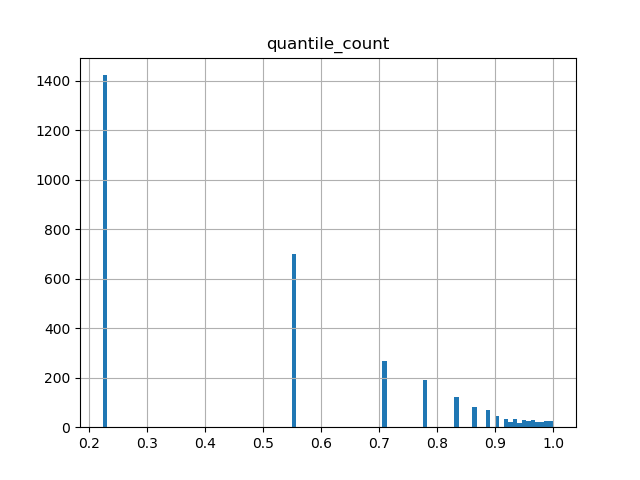

            name type  count  quantile_count
0           aamr   JJ      1        0.223461
1         abduct   NN      1        0.223461
3           abis   NN     16        0.959014
4           able   JJ      7        0.885050
5  abnormalities  NNS      1        0.223461 (3184, 4)


In [10]:
data_word_freq = pd.DataFrame([word_freq_dict]).T.reset_index()
data_word_freq.columns = ['node', 'count']

def get_distinct_nodes(df):    
    df['name'] = df['node'].apply(lambda node: node[0])
    df['type'] = df['node'].apply(lambda node: node[1])
    df['rank'] = df.groupby('name')['count'].rank(ascending=False)
    return df[(df['rank'] == 1)][['name', 'type', 'count']].copy()

nodes_ = get_distinct_nodes(data_word_freq)
    
nodes_['quantile_count'] = nodes_['count'].rank(pct=True)

nodes_.hist(column='quantile_count', bins=100)
print nodes_.head(), nodes_.shape

# Co-Occurrence Calculation

## Helper Functions

In [12]:
def generate_word_combinations(series):
    word_pairs_series = series.apply(
        lambda document:
        [
            [
                sorted(pair) for pair in tuple(
                    combinations([(word,pos) for word, pos in sentence],2)
                )
            ]for sentence in document
        ]
    )
    return word_pairs_series

def generate_word_cooccurrences(series):
    word_combinations_series = generate_word_combinations(series=series)
    combination_dict = dict(
        Counter(
            [
                (w1, w2) for document in word_combinations_series
                            for sentence in document
                                for w1, w2 in sentence]
        )
    )
    
    return [
        {
            'source'       :link[0][0],
            'source_type'  :link[0][1],
            'target'       :link[1][0],
            'target_type'  :link[1][1],
            'weight'       : weight
        } for link, weight in combination_dict.items()
    ]

In [13]:
word_cooccurrences = generate_word_cooccurrences(data_['pos_tagged_filtered'])
data_links_ = pd.DataFrame.from_records(word_cooccurrences)

# Filter Weak Links

In [14]:
def filter_weak_links(df, qmin=0, qmax=1, min_count=1):
    df['rank'] = df.groupby(['source'])['weight'].rank(method='first', ascending=False)
    df = df[(df['rank'] <= 3)].copy()
    df['quantile_weight'] = df['weight'].rank(pct=True)
    df = df[(df['quantile_weight'] >= qmin) & (df['quantile_weight'] <= qmax) & (df['weight'] >= min_count)].copy()
    df['quantile_weight'] = df['weight'].rank(pct=True)
    return df

<IPython.core.display.Javascript object>


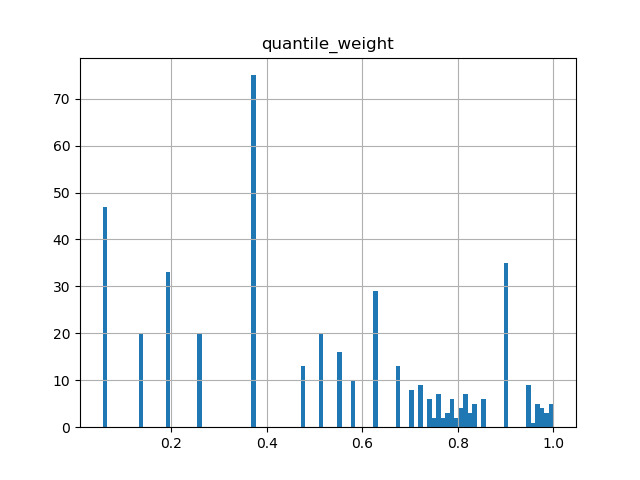

(428, 7)

In [15]:
filtered_links_ = filter_weak_links(data_links_, qmin=0.95, qmax=0.995, min_count=2)
filtered_links_.hist(column='quantile_weight', bins=100)
filtered_links_.shape

# Get All Nodes From Links

In [19]:
def get_nodes_from_links(link_df, nodes_info_df):
    link_nodes = list(set(list(link_df['source']) + list(link_df['target'])))
    print('Distinct nodes from links:- {}'.format(len(link_nodes)))
    nodes_df = pd.DataFrame(link_nodes, columns=['name'])
    nodes_df = nodes_df.merge(nodes_info_df, on='name', how='left')
    return nodes_df

link_nodes_df = get_nodes_from_links(filtered_links_, nodes_)
print 'Mapping Stats:', Counter(link_nodes_df['quantile_count'].isnull())

Distinct nodes from links:- 286
Mapping Stats: Counter({False: 284, True: 2})


# Add more nodes apart from link nodes

In [20]:
relevant_columns = ['name', 'type', 'count']

extra_nodes_df = nodes_[(nodes_['count'].rank(pct=True) >= .92)][relevant_columns].copy()
link_nodes_df = link_nodes_df[relevant_columns]
# all_nodes_df = pd.concat([extra_nodes_df, link_nodes_df])
all_nodes_df = link_nodes_df

print extra_nodes_df.shape, '+', link_nodes_df.shape, '=', all_nodes_df.shape

(252, 3) + (286, 3) = (286, 3)


# Drop duplicate Nodes

In [21]:
all_nodes_df.drop_duplicates(inplace=True)
print 'All nodes after dropping duplicates shape:',all_nodes_df.shape

all_nodes_df['quantile_count'] = all_nodes_df['count'].rank(pct=True)
print 'All nodes head:', '\n',all_nodes_df.head()
# link_nodes_df = link_nodes_df[(link_nodes_df['count'] >= 5)]

All nodes after dropping duplicates shape: (286, 3)
All nodes head: 
        name type  count  quantile_count
0         gw   NN   28.0        0.827465
1         gu   NN   11.0        0.494718
2      young   JJ   32.0        0.867958
3  gentleman   JJ    9.0        0.457746
4     kdrama   NN   33.0        0.875000


# Export Nodes and Links

In [22]:
print 'HEADS'
print filtered_links_.head()
print ''
print all_nodes_df.head()

print 'DESCRIPTIONS'
print ''
print ''
print all_nodes_df.describe()

filtered_links_.to_json(output_graph_links_path, orient='records')
all_nodes_df.to_json(output_graph_nodes_path, orient='records')

HEADS
         source source_type    target target_type  weight  rank  \
481      artist          NN  favorite          JJ      42   1.0   
603           s          NN     slick          NN      43   2.0   
726        nice          JJ   romance          NN      20   1.0   
1962    comfort          NN    miyeon          NN      22   1.0   
2454  freelance          NN    korean          JJ      36   1.0   

      quantile_weight  
481          0.849299  
603          0.897196  
726          0.196262  
1962         0.369159  
2454         0.786215  

        name type  count  quantile_count
0         gw   NN   28.0        0.827465
1         gu   NN   11.0        0.494718
2      young   JJ   32.0        0.867958
3  gentleman   JJ    9.0        0.457746
4     kdrama   NN   33.0        0.875000
DESCRIPTIONS


            count  quantile_count
count  284.000000      284.000000
mean    16.411972        0.501761
std     18.288501        0.288609
min      1.000000        0.008803
25%      4.0000